In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from importlib import reload
import models_new
reload(models_new)
from models_new import Renorm_Dynamic
from EI_calculation import approx_ei

import dynamic_models_sis_new
reload(dynamic_models_sis_new)
from dynamic_models_sis_new import Simple_Spring_Model
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:2') if use_cuda else torch.device('cpu')
from numba import jit
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

def kde_density(X):
    is_cuda = X.is_cuda  #True is stored in GPU.
    ldev = X.device  #Running the allocation of memory within a certain space.
    dim = X.size()[1] #The number of columns in obtaining the data is the dimension.
    kde = KernelDensity(kernel='gaussian', bandwidth=0.02, atol=0.2).fit(X.cpu().data.numpy())
    log_density = kde.score_samples(X.cpu().data.numpy())
    return log_density, kde



def to_weights(log_w, temperature): 
    #Normalize log_w using softmax and obtain the weights.
    logsoft = nn.LogSoftmax(dim = 0)
    weights = torch.exp(logsoft(log_w/temperature))
    return weights



def test_model_causal_multi_sis(spring_data,samples,MAE_raw,net1,sigma,scale,L=0.5, num_samples = 1000, bigL = 100):
    #EI calculation function
    sigmas_matrix=torch.zeros([2,2],device=device)
    s,sp,l,lp=spring_data
    encode=net1.encoding(sp)
    predicts1, latent1, latentp1 = net1(s)
    log_density, k_model_n = kde_density(latent1)
    log_rho = - scale * torch.log(2.0*torch.from_numpy(np.array(L)))  #Uniform distribution probability distribution
    logp = log_rho - log_density  #The difference between two probability distributions.
    weights = to_weights(logp, temperature) * samples
    if use_cuda:
        weights = weights.cuda(device=device)
    weights=weights.unsqueeze(1)
    mae1 = MAE_raw(latentp1, encode) * torch.cat((weights,weights),1)
    sigmas=mae1.mean(axis=0)
    
    sigmas_matrix = torch.diag(sigmas)
    ei = approx_ei(scale, scale, sigmas_matrix.data, lambda x:(net1.dynamics(x.unsqueeze(0))+x.unsqueeze(0)), 
                       num_samples = 1000, L=bigL, easy=True, device=device) 

    return ei, sigmas,weights

def calculate_net_model2(model,s,i,steps = 100,stochastic=False,seed=10,rou=-0.5):
    #Out-of-distribution generalization testing function
    spring = Simple_Spring_Model(device=device)

    if stochastic:
        z = torch.randn([1, 2], device=device)*L/2 
    else:
        z=torch.tensor([[s,i]],device=device) 
    s = spring.perturb(z, sigma,rou)
    #s=(s-s.mean())/s.std()
    s_hist, z_hist = model.multi_step_prediction(s, steps)
    if use_cuda:
        s_hist = s_hist.cpu()
        z_hist = z_hist.cpu()

    rs_hist, rsn_hist = spring.multi_steps_sir(z, steps, sigma,rou=rou) #sir
    if use_cuda:
        rs_hist = rs_hist.cpu()
        rsn_hist = rsn_hist.cpu()

    means=torch.mean(torch.abs(rsn_hist-s_hist),1)
    cums=torch.cumsum(means, 0)
    mae_fin=cums.data/np.linspace(1, steps+1, steps+1)


    return mae_fin[-1]

from datetime import datetime
t0 = datetime.now()
def cpt(s):
    #Timing function
    global t0
    t = datetime.now()
    print(f'check point{s:->10}-> {t.time()}; lasting {t - t0} seconds')
    t0 = t
device

device(type='cpu')

In [5]:
#Calculate network parameters
sz=4
scale=2
hidden_units = 64
hidden_units2=128
net2=nn.Sequential(nn.Linear(sz, hidden_units), nn.LeakyReLU(), 
                     nn.Linear(hidden_units, hidden_units2), nn.LeakyReLU(), 
                       nn.Linear(hidden_units2, hidden_units2), nn.LeakyReLU(),
                       nn.Linear(hidden_units2, hidden_units), nn.LeakyReLU(),
                                         nn.Linear(hidden_units, sz))
net = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)

37404

In [ ]:
results = []
results_nn = []
encoder_results = []
temperature = 1
encoder_interval = 1000
experiments = 1
sz = 4
scale = 2
L = 1
hidden_units = 64
sigma = 0.03
steps = 7
batch_size = steps * 100 #20
mae2_w= 3
rou=-0.5
cpt('begin')
z_scale=sz-scale
prior = distributions.MultivariateNormal(torch.zeros(z_scale), torch.eye(z_scale))
MAE = torch.nn.L1Loss()
MAE_raw = torch.nn.L1Loss(reduction='none')
test_start=0
test_end=0.3
m_step=10
for experiment in range(experiments):
    mul_batch_size = [0,10,4500,1500]
    seed = 1+experiment
    mae3_w = 0 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5) #sir
    ss,sps,ls,lps = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5) #sir
    sample_num = ss.size()[0] 
    weights2 = torch.ones(sample_num, device=device) 
    net_nn = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
    #Initialize network parameters using specific methods.
    net_nn.load_state_dict(torch.load('netnn_init_trnorm0.1+zero_seed=4.mdl').state_dict())
            
    nname="_trnorm0.1+zero_4_501"    
    net_nn.to(device=device)
    optimizer2 = torch.optim.Adam([p for p in net_nn.parameters() if p.requires_grad==True], lr=1e-4)    
    result_nn = []
    ei_nn=[]
    term1_nn=[]
    term2_nn=[]
    losses_nn=[]
    MAEs_nn=[]
    data_models = []
    spring = Simple_Spring_Model(device=device)
    T  = 3001
    T2  = 30001 
    T3  = 150001
    cpt('out')
    for epoch in range(T2):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp = ss[start:end], sps[start:end], ls[start:end], lps[start:end]
        predicts, latent, latentp,z = net_nn.forward_train(s,sp)
        mae = MAE(sp, predicts)
        loss_nn= mae 
        optimizer2.zero_grad()
        loss_nn.backward()
        optimizer2.step()

        
        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_nn=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 
                mae_nn+=calculate_net_model2(net_nn,s,i,steps=m_step,seed=seed,rou=rou)
            mae_nn/=20
            ei1, sigmas1,weightsnn=test_model_causal_multi_sis(spring_data,10000,MAE_raw,net_nn,sigma,scale, L=L,num_samples = 1000, bigL = L)
            print('Train loss: CommonNet= %.4f' %  mae.item())
            print('dEI: CommonNet= %.4f' % ei1[0]) 
            print('term1: CommonNet= %.4f'% ei1[3])
            print('term2: CommonNet= %.4f'% ei1[4])
            print(120*'-')
  
            ei_nn.append(ei1[0])
            term1_nn.append(ei1[3].item())
            term2_nn.append(ei1[4].item())
            losses_nn.append(mae.item())
            
            result_nn.append([ei1[0], ei1[3].item(), ei1[4].item(),mae_nn.item()]) #
            cpt('o_1')
            
   
    results_nn.append(result_nn)

##########################################################################################################################    
    #Resetting the random seed for the experiment.
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Generating Data
    spring = Simple_Spring_Model(device=device)
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5) #sir
    ss,sps,ls,lps = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5) #sir

    sample_num = ss.size()[0] 
    weights = torch.ones(sample_num, device=device) 

    net = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)


    net.load_state_dict(torch.load('netwn_init_trnorm0.1+zero_seed=4.mdl').state_dict())
   
    net.to(device=device)
    optimizer1 = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)  
    optimizer3 = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)
    
    result = []
    ei_net=[]
    term1_net=[]
    term2_net=[]
    loss_net=[]
    MAEs_net=[]
    data_models = []
    spring = Simple_Spring_Model(device=device)
    cpt('out')
    for epoch in range(T):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp, w = ss[start:end], sps[start:end], ls[start:end], lps[start:end], weights[start:end]
        
        predicts1, latent1, latentp1,z1 = net.forward_train(s,sp)
        mae1 =  MAE(sp, predicts1) #Forward error
        loss = mae1 
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        #Parallel training of inverse dynamics in the first stage.
        for p in net.flow.parameters():
            p.requires_grad = False
            
        latent1=net.encoding(s)
        predicts0, latent0, latentp0 = net.back_forward(sp) 
        mae2 = (MAE_raw(latent1, latentp0).mean(axis=1) * w).mean()  #
        optimizer3.zero_grad()
        mae2.backward()
        optimizer3.step()
        
        for p in net.flow.parameters():
            p.requires_grad = True
            
    
       
        
        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_net=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2
                mae_net+=calculate_net_model2(net,s,i,steps=m_step,seed=seed,rou=rou)
            mae_net/=20
            

            ei0, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,10000,MAE_raw,net,sigma,scale, L=L,num_samples = 1000, bigL = L)
        
            print('dEI: BiNet= %.4f' % ei0[0])  
            print('term1: BiNet= %.4f ' % ei0[3])
            print('term2: BiNet= %.4f '% ei0[4])
            print(120*'-')
            ei_net.append(ei0[0])
            term1_net.append(ei0[3].item())
            term2_net.append(ei0[4].item())
            loss_net.append(mae1.item())

            
            result.append([ei0[0],ei0[3].item(), ei0[4].item(),mae_net.item()]) #
            cpt('o_1')
            
    for epoch in range(T,T2):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp, w = ss[start:end], sps[start:end], ls[start:end], lps[start:end], weights[start:end]

        predicts1, latent1, latentp1, z1 = net.forward_train(s,sp)
        predicts0, latent0, latentp0 = net.back_forward(sp) 
        mae1 = (MAE_raw(sp, predicts1).mean(axis=1) * w).mean() 
        mae2 = (MAE_raw(latent1,latentp0).mean(axis=1) * w).mean()  #The error of coming back in the opposite direction.
        loss = mae1+mae2_w*mae2 #Inverse dynamics learner
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        #Inverse probability weighting
        if epoch > 0 and epoch % encoder_interval == 0:
            cpt('w_0')
            #Resampling of training data is performed here, which varies according to the changes in the encoder.
            net_temp = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=False, device = device)
            net_temp.load_state_dict(net.state_dict())
            net_temp.to(device=device)
            encodings = net_temp.encoding(ss)  #Encoding of data collected by Spring.
            cpt('w_1')
            log_density, k_model_n = kde_density(encodings)  #Probability distribution of the encoded raw data.
            cpt('w_2')
            log_rho = - scale * torch.log(2.0*torch.from_numpy(np.array(L)))  
            logp = log_rho - log_density 
            weights = to_weights(logp, temperature) * sample_num
            if use_cuda:
                weights = weights.cuda(device=device)
            weights=torch.where(weights<10,weights,10.)
            cpt('w_3')
       

        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_net=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 
                mae_net+=calculate_net_model2(net,s,i,steps=m_step,seed=seed,rou=rou)
            mae_net/=20
            ei0, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,10000,MAE_raw,net,sigma,scale, L=L,num_samples = 1000, bigL = L)

            print('dEI: BiNet= %.4f' % ei0[0])  
            print('term1: BiNet= %.4f ' % ei0[3])
            print('term2: BiNet= %.4f '% ei0[4])
            print(120*'-')
            result.append([ei0[0],ei0[3].item(), ei0[4].item(),mae_net.item()])
            ei_net.append(ei0[0])
            term1_net.append(ei0[3].item())
            term2_net.append(ei0[4].item())
            loss_net.append(mae1.item())

            cpt('o_1')
         
    results.append(result)  
#Save Result
import pickle
with open('5 OOD L=1 717.pkl', 'wb') as f:
     pickle.dump((results,results_nn), f)   


check point-----begin-> 14:51:59.503940; lasting 0:00:30.238760 seconds
check point-------out-> 14:52:01.062941; lasting 0:00:01.559001 seconds
check point-------o_0-> 14:52:01.125274; lasting 0:00:00.062333 seconds
0 / 1 Epoch: 0
Train loss: CommonNet= 0.4738
dEI: CommonNet= 0.7818
term1: CommonNet= 0.1376
term2: CommonNet= 1.4259
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:52:03.208871; lasting 0:00:02.083597 seconds
check point-------o_0-> 14:52:17.595182; lasting 0:00:14.386311 seconds
0 / 1 Epoch: 500
Train loss: CommonNet= 0.1051
dEI: CommonNet= 0.9939
term1: CommonNet= 0.3393
term2: CommonNet= 1.6485
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:52:20.462914; lasting 0:00:02.867732 seconds
check point-------o_0-> 14:52:35.734729; lasting 0:00:15.271815 seconds
0 / 1 Epoch: 100

check point-------o_0-> 15:01:52.048879; lasting 0:00:23.350273 seconds
0 / 1 Epoch: 10500
Train loss: CommonNet= 0.0287
dEI: CommonNet= 2.0887
term1: CommonNet= 2.6866
term2: CommonNet= 1.4908
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:02:02.620652; lasting 0:00:10.571773 seconds
check point-------o_0-> 15:02:28.815006; lasting 0:00:26.194354 seconds
0 / 1 Epoch: 11000
Train loss: CommonNet= 0.0289
dEI: CommonNet= 2.0622
term1: CommonNet= 2.6380
term2: CommonNet= 1.4863
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:02:42.396105; lasting 0:00:13.581099 seconds
check point-------o_0-> 15:03:05.720563; lasting 0:00:23.324458 seconds
0 / 1 Epoch: 11500
Train loss: CommonNet= 0.0282
dEI: CommonNet= 2.1774
term1: CommonNet= 2.8704
term2: CommonNet= 1.4843
--------------------------------

Train loss: CommonNet= 0.0280
dEI: CommonNet= 2.3657
term1: CommonNet= 3.3082
term2: CommonNet= 1.4232
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:18:53.933285; lasting 0:00:12.091820 seconds
check point-------o_0-> 15:19:16.037138; lasting 0:00:22.103853 seconds
0 / 1 Epoch: 21500
Train loss: CommonNet= 0.0283
dEI: CommonNet= 2.3776
term1: CommonNet= 3.3340
term2: CommonNet= 1.4211
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:19:25.934595; lasting 0:00:09.897457 seconds
check point-------o_0-> 15:19:47.921491; lasting 0:00:21.986896 seconds
0 / 1 Epoch: 22000
Train loss: CommonNet= 0.0281
dEI: CommonNet= 2.3759
term1: CommonNet= 3.3376
term2: CommonNet= 1.4142
------------------------------------------------------------------------------------------------------------------------
ch

check point-------o_0-> 15:32:58.944312; lasting 0:00:49.667606 seconds
0 / 1 Epoch: 1500
dEI: BiNet= 1.6030
term1: BiNet= 1.6332 
term2: BiNet= 1.5727 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:33:07.781170; lasting 0:00:08.836858 seconds
check point-------o_0-> 15:34:02.822846; lasting 0:00:55.041676 seconds
0 / 1 Epoch: 2000
dEI: BiNet= 1.6522
term1: BiNet= 1.7519 
term2: BiNet= 1.5525 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:34:09.410846; lasting 0:00:06.588000 seconds
check point-------o_0-> 15:34:52.509013; lasting 0:00:43.098167 seconds
0 / 1 Epoch: 2500
dEI: BiNet= 1.6584
term1: BiNet= 1.7693 
term2: BiNet= 1.5476 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:35:01.0

check point-------o_0-> 16:11:25.715615; lasting 0:00:33.620916 seconds
0 / 1 Epoch: 10500
dEI: BiNet= 2.7448
term1: BiNet= 4.0345 
term2: BiNet= 1.4551 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:11:36.814803; lasting 0:00:11.099188 seconds
check point-------w_0-> 16:12:21.259000; lasting 0:00:44.444197 seconds
check point-------w_1-> 16:12:21.788588; lasting 0:00:00.529588 seconds
check point-------w_2-> 16:22:48.716592; lasting 0:10:26.928004 seconds
check point-------w_3-> 16:22:48.719585; lasting 0:00:00.002993 seconds
check point-------o_0-> 16:22:48.719585; lasting 0:00:00 seconds
0 / 1 Epoch: 11000
dEI: BiNet= 2.7425
term1: BiNet= 4.0340 
term2: BiNet= 1.4510 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:22:59.729879; lasting 0:00:11.010294 seconds
check point-------o_0-> 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#Draw grid points for the vector field.
def mesh(density):
    p1 = np.array([0, 0])
    p2 = np.array([0, 1])
    p3 = np.array([1, 0])

    #Generate an array of coordinates for grid points.
    x_min, x_max = -1, 6
    y_min, y_max = -1, 6
    x_range = np.arange(x_min, x_max, density)
    y_range = np.arange(y_min, y_max, density)
    X, Y = np.meshgrid(x_range, y_range)

    # Determine if each grid point is inside the right-angled triangle.
    in_triangle = np.zeros(X.shape, dtype=bool)
    for i in range(len(X)):
        for j in range(len(X[i])):
            p = np.array([X[i][j], Y[i][j]])
            if p[0] >= 0 and p[1] >= 0 and p[0]+p[1] <= 1 :
                in_triangle[i, j] = True

    # Grid points marked within a right-angled triangle.
    x_in = X[in_triangle]
    y_in = Y[in_triangle]

    return x_in, y_in

mesh(0.05)

(array([8.8817842e-16, 5.0000000e-02, 1.0000000e-01, 1.5000000e-01,
        2.0000000e-01, 2.5000000e-01, 3.0000000e-01, 3.5000000e-01,
        4.0000000e-01, 4.5000000e-01, 5.0000000e-01, 5.5000000e-01,
        6.0000000e-01, 6.5000000e-01, 7.0000000e-01, 7.5000000e-01,
        8.0000000e-01, 8.5000000e-01, 9.0000000e-01, 9.5000000e-01,
        8.8817842e-16, 5.0000000e-02, 1.0000000e-01, 1.5000000e-01,
        2.0000000e-01, 2.5000000e-01, 3.0000000e-01, 3.5000000e-01,
        4.0000000e-01, 4.5000000e-01, 5.0000000e-01, 5.5000000e-01,
        6.0000000e-01, 6.5000000e-01, 7.0000000e-01, 7.5000000e-01,
        8.0000000e-01, 8.5000000e-01, 9.0000000e-01, 8.8817842e-16,
        5.0000000e-02, 1.0000000e-01, 1.5000000e-01, 2.0000000e-01,
        2.5000000e-01, 3.0000000e-01, 3.5000000e-01, 4.0000000e-01,
        4.5000000e-01, 5.0000000e-01, 5.5000000e-01, 6.0000000e-01,
        6.5000000e-01, 7.0000000e-01, 7.5000000e-01, 8.0000000e-01,
        8.5000000e-01, 8.8817842e-16, 5.0000000e

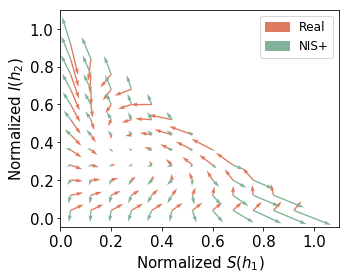

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import solve_ivp
import seaborn as sns
def SIR(s,i,lam=1,miu=0.5):
    ds=-lam * s * i
    di=lam * s * i - miu * i
    return ds, di

S, I = mesh(0.08)
colorlabel = ['#F4F1DE','#DF7A5E','#3C405B','#82B29A','#F2CC8E']
colors=[colorlabel[1]]*len(S)+[colorlabel[3]]*len(S)
SI=torch.tensor([S,I],dtype=torch.float,device=device)
SI=SI.t()
SI=spring.perturb(SI, sigma=0.001,rou=rou)
SI=net.encoding(SI)
# Calculate the vector at each grid point.
dd= net.dynamics(SI).cpu().data.numpy()
dSdt1=dd[:,0]
dIdt1=dd[:,1]
S1=SI[:,0].cpu().data.numpy()
I1=SI[:,1].cpu().data.numpy()
dSdt,dIdt = SIR(S,I)
S=list(S)+list(S)
I=list(I)+list(I)
n=1
m=1
dSdt1_m,dIdt1_m=np.mean(dSdt1),np.mean(dIdt1)
dSdt_m,dIdt_m=np.mean(dSdt),np.mean(dIdt)
dSdt1,dIdt1=(dSdt1-dSdt1_m)**n/np.std(dSdt1),(dIdt1-dIdt1_m)**n/np.std(dIdt1)
dSdt,dIdt=(dSdt-dSdt_m)**n/np.std(dSdt),(dIdt-dIdt_m)**n/np.std(dIdt)
dSdt1,dIdt1=m*dSdt1,m*dIdt1
dSdt=list(dSdt)+list(dSdt1)
dIdt=list(dIdt)+list(dIdt1)
fig,ax = plt.subplots(figsize=(5,4))
# Plotting vector fields on phase space.
quiver = ax.quiver(S, I, dSdt, dIdt,color=colors)
red_patch = matplotlib.patches.Patch(color=colorlabel[1], label='Real')
green_patch = matplotlib.patches.Patch(color=colorlabel[3], label='NIS+')
plt.legend(handles=[red_patch, green_patch],loc='best', fontsize=12)

# Set graphic title and axis labels.
plt.xlabel('Normalized $S(h_1)$',fontsize=15)
plt.ylabel('Normalized $I(h_2)$',fontsize=15)

# Set the range of the coordinate axis.
ax.set_xlim(0, 1.1)
ax.set_ylim(-0.05, 1.1)
ax.tick_params(labelsize=15)

plt.show()